In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/VKR_Malceva')

Mounted at /content/drive


# Data

In [2]:
print("="*60)
print("ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ДЛЯ LIGHTGBM")
print("="*60)

# 1. Загрузка данных
print("1. Загрузка данных...")
train_df = pd.read_csv('./data/train_processed.csv')
val_df = pd.read_csv('./data/val_processed.csv')

# 2. Разделение на признаки и таргет
print("2. Разделение данных...")
X_train = train_df.drop(columns=['TARGET'])
y_train = train_df['TARGET']
X_val = val_df.drop(columns=['TARGET'])
y_val = val_df['TARGET']

# 3. Исправление названий столбцов для LightGBM
print("3. Исправление названий столбцов...")

def fix_column_names(df):
    """Исправляет названия столбцов для совместимости с LightGBM"""
    df_fixed = df.copy()
    new_columns = {}
    
    for col in df_fixed.columns:
        # Заменяем все не-буквенно-цифровые символы на подчеркивание
        new_name = str(col)
        # Заменяем пробелы и основные проблемные символы
        for char in [' ', '(', ')', '[', ']', '{', '}', '/', '\\', ':', ',', '.', '-', '+', '*', '&', '^', '%', '$', '#', '@', '!', '?']:
            new_name = new_name.replace(char, '_')
        
        # Убираем множественные подчеркивания
        while '__' in new_name:
            new_name = new_name.replace('__', '_')
        
        # Убираем подчеркивания в начале/конце
        new_name = new_name.strip('_')
        
        # Если имя пустое или начинается с цифры
        if not new_name:
            new_name = f'feature_{col}'
        elif new_name[0].isdigit():
            new_name = f'f_{new_name}'
        
        new_columns[col] = new_name
    
    return df_fixed.rename(columns=new_columns)

X_train = fix_column_names(X_train)
X_val = fix_column_names(X_val)

print(f"   Переименовано {X_train.shape[1]} столбцов")
print(f"   Пример: '{list(train_df.columns)[0]}' -> '{X_train.columns[0]}'")

# 4. Оптимизация типов данных
print("4. Оптимизация типов данных...")

# Целевая переменная -> int8
y_train = y_train.astype(np.int8)
y_val = y_val.astype(np.int8)

# Бинарные признаки (0/1) -> int8
binary_mask = (X_train.nunique() <= 2) & (X_train.isin([0, 1]).all())
binary_cols = X_train.columns[binary_mask].tolist()

if binary_cols:
    X_train[binary_cols] = X_train[binary_cols].astype(np.int8)
    X_val[binary_cols] = X_val[binary_cols].astype(np.int8)
    print(f"   Бинарных признаков: {len(binary_cols)} -> int8")

# Остальные признаки -> float32
other_cols = [col for col in X_train.columns if col not in binary_cols]
if other_cols:
    X_train[other_cols] = X_train[other_cols].astype(np.float32)
    X_val[other_cols] = X_val[other_cols].astype(np.float32)
    print(f"   Непрерывных признаков: {len(other_cols)} -> float32")

# 5. Удаление признаков с нулевой дисперсией
print("5. Удаление признаков с нулевой дисперсией...")
zero_var_cols = X_train.columns[X_train.std() == 0]
if len(zero_var_cols) > 0:
    X_train = X_train.drop(columns=zero_var_cols)
    X_val = X_val.drop(columns=zero_var_cols)
    print(f"   Удалено {len(zero_var_cols)} признаков с нулевой дисперсией")
else:
    print("   Признаков с нулевой дисперсией не найдено")

# 6. Очистка памяти
print("6. Очистка памяти...")
del train_df, val_df
import gc
gc.collect()

# 7. Итоговые результаты
print("\n" + "="*60)
print("ИТОГОВЫЕ РАЗМЕРЫ ДАННЫХ")
print("="*60)

print(f"X_train: {X_train.shape} (память: {X_train.memory_usage().sum()/1024**2:.1f} MB)")
print(f"X_val:   {X_val.shape} (память: {X_val.memory_usage().sum()/1024**2:.1f} MB)")
print(f"y_train: {y_train.shape} (тип: {y_train.dtype})")
print(f"y_val:   {y_val.shape} (тип: {y_val.dtype})")

print(f"\nТипы признаков в X_train:")
for dtype in X_train.dtypes.unique():
    count = (X_train.dtypes == dtype).sum()
    print(f"  {dtype}: {count} признаков")

print(f"\nПроверка пропущенных значений:")
print(f"  X_train: {X_train.isna().sum().sum()}")
print(f"  X_val:   {X_val.isna().sum().sum()}")

print(f"\nПримеры названий признаков:")
print(f"  {list(X_train.columns[:3])}")

print("\n" + "="*60)
print("ДАННЫЕ ГОТОВЫ ДЛЯ LIGHTGBM!")
print("="*60)

ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ДЛЯ LIGHTGBM
1. Загрузка данных...
2. Разделение данных...
3. Исправление названий столбцов...
   Переименовано 702 столбцов
   Пример: 'SK_ID_CURR' -> 'SK_ID_CURR'
4. Оптимизация типов данных...
   Бинарных признаков: 115 -> int8
   Непрерывных признаков: 587 -> float32
5. Удаление признаков с нулевой дисперсией...
   Удалено 5 признаков с нулевой дисперсией
6. Очистка памяти...

ИТОГОВЫЕ РАЗМЕРЫ ДАННЫХ
X_train: (184506, 697) (память: 432.5 MB)
X_val:   (61502, 697) (память: 144.2 MB)
y_train: (184506,) (тип: int8)
y_val:   (61502,) (тип: int8)

Типы признаков в X_train:
  float32: 587 признаков
  int8: 110 признаков

Проверка пропущенных значений:
  X_train: 0
  X_val:   0

Примеры названий признаков:
  ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL']

ДАННЫЕ ГОТОВЫ ДЛЯ LIGHTGBM!


# XGBoost

In [5]:
print("="*80)
print("БЛОК 1: ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ XGBOOST")
print("="*80)

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# 1. Создаем базовую модель
print("\n1. Создание базовой модели XGBoost...")
base_xgb = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,           # Используем все ядра
    verbosity=0,         # Без вывода
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Определяем сетку гиперпараметров для RandomizedSearchCV
print("\n2. Определение сетки гиперпараметров...")
param_distributions = {
    # Количество деревьев
    'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
    
    # Темп обучения
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    
    # Глубина деревьев
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 12, 15],
    
    # Минимальное количество наблюдений в листе
    'min_child_weight': [1, 3, 5, 7, 10, 15, 20],
    
    # Субдискретизация
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bynode': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    # Регуляризация
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10],  # L1
    'reg_lambda': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10], # L2
    
    # Гамма (min_split_loss)
    'gamma': [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
    
    # Дисбаланс классов
    'scale_pos_weight': [1, 2, 3, 5, 10, (y_train == 0).sum() / (y_train == 1).sum()],
    
    # Деревья
    'grow_policy': ['depthwise', 'lossguide'],
    'max_leaves': [0, 10, 20, 30, 40, 50, 100],  # 0 = ограничено max_depth
    
    # Случайность
    'sampling_method': ['uniform', 'gradient_based']
}

print(f"   Всего параметров для поиска: {sum(len(v) if isinstance(v, list) else 1 for v in param_distributions.values())}")

# 3. Настройка RandomizedSearchCV
print("\n3. Настройка RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_distributions,
    n_iter=30,           # 30 случайных комбинаций
    cv=3,                # 3 фолда кросс-валидации
    scoring='roc_auc',   # Метрика для оптимизации
    n_jobs=1,            # XGBoost уже параллелит, тут ставим 1
    verbose=10,          # Детальный вывод прогресса
    random_state=42,
    refit=False,         # Пока не обучаем финальную модель
    return_train_score=True
)

# 4. Запуск поиска гиперпараметров
print("\n4. Запуск поиска лучших гиперпараметров...")
print(f"   Будет проверено {30 * 3} моделей (30 итераций × 3 фолда)")
print(f"   Размер данных: {X_train.shape}")
print(f"   Оценка времени: ~{30 * 3 * 2 / 60:.1f}-{30 * 3 * 5 / 60:.1f} минут")
print("-"*80)

import time
start_time = time.time()
random_search.fit(X_train, y_train)
search_time = time.time() - start_time

# 5. Результаты поиска
print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ ПОИСКА ГИПЕРПАРАМЕТРОВ XGBOOST")
print("="*80)

print(f"Поиск завершен за {search_time/60:.1f} минут")
print(f"\nЛучшие параметры:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nЛучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

# 6. Показываем топ-5 комбинаций параметров
print("\nТоп-5 лучших комбинаций параметров:")
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df.sort_values('mean_test_score', ascending=False).head(5)

for i, (_, row) in enumerate(top_results.iterrows(), 1):
    params = row['params']
    print(f"\n{i}. Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"   n_estimators={params.get('n_estimators')}, learning_rate={params.get('learning_rate')}, "
          f"max_depth={params.get('max_depth')}")

# 7. Сохраняем лучшие параметры в файл
print("\n" + "="*80)
print("СОХРАНЕНИЕ ЛУЧШИХ ПАРАМЕТРОВ")
print("="*80)

best_params = random_search.best_params_

# Конвертируем numpy типы в стандартные Python типы
clean_best_params = {}
for key, value in best_params.items():
    if isinstance(value, (np.integer, np.floating)):
        clean_best_params[key] = value.item()
    else:
        clean_best_params[key] = value

import json
import joblib

# Сохраняем в JSON
with open('./models/xgb_best_params.json', 'w') as f:
    json.dump(clean_best_params, f, indent=2)

# Сохраняем весь объект поиска
search_results = {
    'best_params': clean_best_params,
    'best_score': random_search.best_score_,
    'cv_results': results_df.to_dict('records'),
    'search_time_minutes': search_time / 60
}

joblib.dump(search_results, './models/xgb_search_results.pkl')

print(f"\n✅ Лучшие параметры сохранены:")
print(f"   JSON: ./models/xgb_best_params.json")
print(f"   Полные результаты: ./models/xgb_search_results.pkl")

БЛОК 1: ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ XGBOOST

1. Создание базовой модели XGBoost...

2. Определение сетки гиперпараметров...
   Всего параметров для поиска: 94

3. Настройка RandomizedSearchCV...

4. Запуск поиска лучших гиперпараметров...
   Будет проверено 90 моделей (30 итераций × 3 фолда)
   Размер данных: (184506, 697)
   Оценка времени: ~3.0-7.5 минут
--------------------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.7, gamma=0, grow_policy=lossguide, learning_rate=0.3, max_depth=7, max_leaves=10, min_child_weight=15, n_estimators=100, reg_alpha=0.001, reg_lambda=10, sampling_method=gradient_based, scale_pos_weight=11.38710976837865, subsample=0.6
[CV 1/3; 1/30] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.7, gamma=0, grow_policy=lossguide, learning_rate=0.3, max_depth=7, max_leaves=10, min_child_wei

In [3]:
print("="*80)
print("БЛОК 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ XGBOOST")
print("="*80)

import json
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка лучших параметров
print("\n1. Загрузка лучших параметров...")
try:
    with open('./models/xgb_best_params.json', 'r') as f:
        best_params = json.load(f)
    print(f"✅ Загружено {len(best_params)} параметров")
    print(f"Параметры: {best_params}")
except FileNotFoundError:
    print("❌ Файл с параметрами не найден!")
    print("Использую параметры по умолчанию...")
    best_params = {
        'n_estimators': 300,
        'learning_rate': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }

# 2. Создание финальной модели
print("\n2. Создание финальной модели XGBoost...")
final_xgb = xgb.XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    verbosity=1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Обучение на всех тренировочных данных
print(f"\n3. Обучение на всех {len(X_train)} samples...")
print(f"   Размер данных: {X_train.shape}")
print(f"   Количество признаков: {X_train.shape[1]}")

import time
train_start = time.time()
final_xgb.fit(X_train, y_train)
train_time = time.time() - train_start

print(f"\n✅ Модель обучена за {train_time/60:.1f} минут")
print(f"   Количество деревьев: {final_xgb.n_estimators}")
print(f"   Фактически построено: {len(final_xgb.get_booster().get_dump())}")

# 4. Сохраняем модель для следующего блока
print("\n4. Сохранение модели...")
temp_model = './models/xgb_temp_model.pkl'
joblib.dump(final_xgb, temp_model)
print(f"   Модель сохранена временно: {temp_model}")

БЛОК 2: ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ XGBOOST

1. Загрузка лучших параметров...
✅ Загружено 15 параметров
Параметры: {'subsample': 0.6, 'scale_pos_weight': 5, 'sampling_method': 'uniform', 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 400, 'min_child_weight': 20, 'max_leaves': 10, 'max_depth': 10, 'learning_rate': 0.1, 'grow_policy': 'depthwise', 'gamma': 0.2, 'colsample_bytree': 0.8, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}

2. Создание финальной модели XGBoost...

3. Обучение на всех 184506 samples...
   Размер данных: (184506, 697)
   Количество признаков: 697

✅ Модель обучена за 0.5 минут
   Количество деревьев: 400
   Фактически построено: 400

4. Сохранение модели...
   Модель сохранена временно: ./models/xgb_temp_model.pkl


БЛОК 3: ОЦЕНКА МЕТРИК И ВИЗУАЛИЗАЦИЯ XGBOOST

1. Загрузка обученной модели...
✅ Модель загружена

2. Предсказания на валидации (61502 samples)...

3. Расчет метрик...

РЕЗУЛЬТАТЫ XGBOOST НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ

Основные метрики:
  Accuracy:   0.8653
  Precision:  0.6080
  Recall:     0.6514
  F1 Macro:   0.6237
  ROC-AUC:    0.7726

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     56537
           1       0.27      0.40      0.32      4965

    accuracy                           0.87     61502
   macro avg       0.61      0.65      0.62     61502
weighted avg       0.89      0.87      0.88     61502


------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------
[[51252  5285]
 [ 2997  1968]]


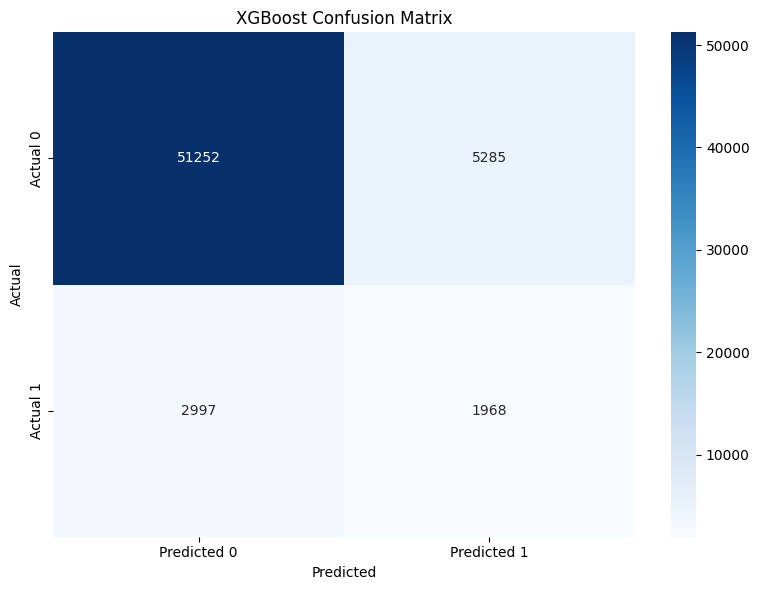

   Confusion Matrix сохранена: ./models/xgb_confusion_matrix.png


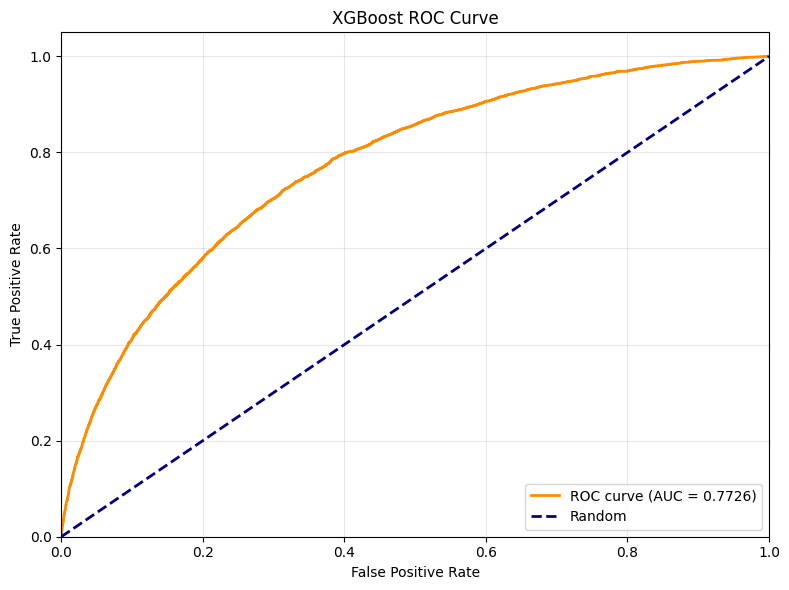

   ROC Curve сохранена: ./models/xgb_roc_curve.png

ВАЖНОСТЬ ПРИЗНАКОВ XGBOOST

Топ-30 самых важных признаков:
                                             feature  importance
                                        EXT_SOURCE_3        95.0
                                        EXT_SOURCE_2        92.0
                                          DAYS_BIRTH        71.0
                                          AMT_CREDIT        66.0
                                         AMT_ANNUITY        58.0
                      bureau_DAYS_CREDIT_ENDDATE_max        48.0
             client_installments_AMT_PAYMENT_min_sum        47.0
                                     DAYS_ID_PUBLISH        43.0
                                       DAYS_EMPLOYED        42.0
                              bureau_DAYS_CREDIT_max        37.0
      client_installments_DAYS_ENTRY_PAYMENT_max_max        35.0
          client_cash_CNT_INSTALMENT_FUTURE_mean_max        34.0
                                    AMT_INCO

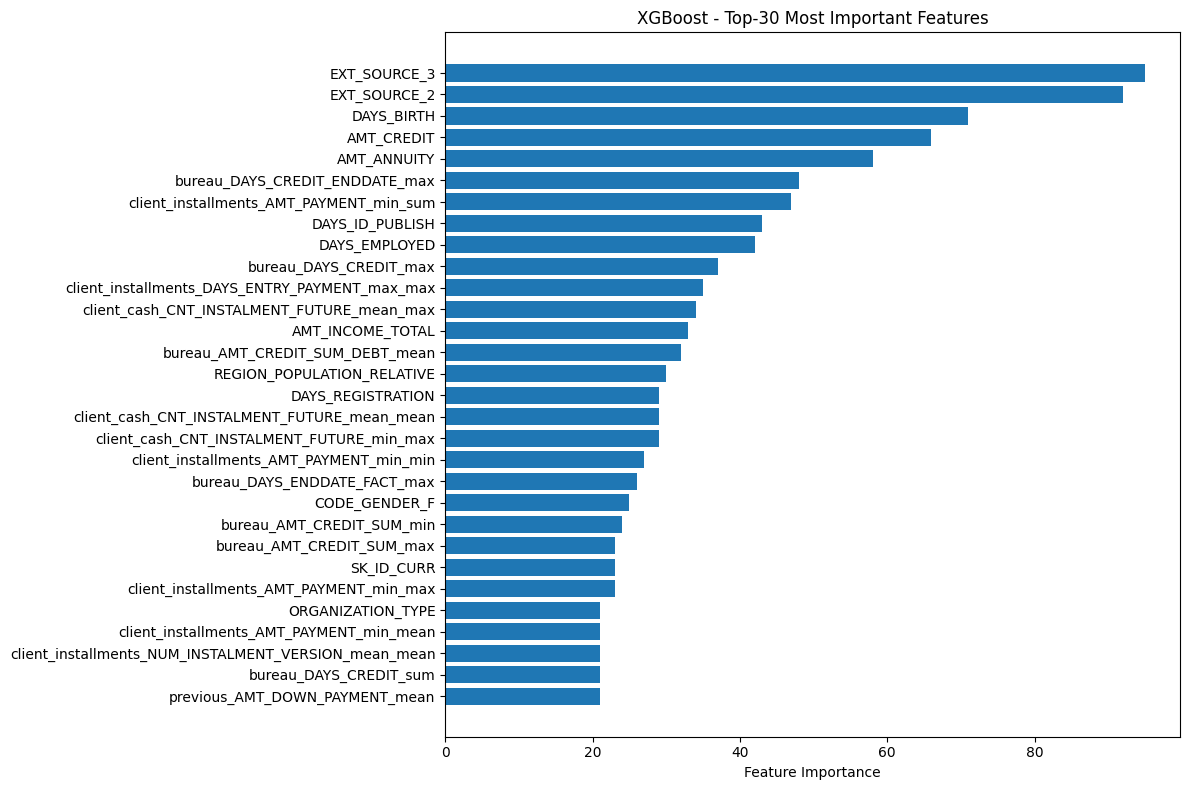

   Важность признаков сохранена: ./models/xgb_feature_importance.png

СОХРАНЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ
✅ Финальная модель сохранена: './models/xgb_final_model.pkl'
✅ Важность признаков сохранена: './models/xgb_feature_importance.csv'

ИТОГОВАЯ ИНФОРМАЦИЯ О XGBOOST МОДЕЛИ

Модель: XGBoost Classifier
Валидационный ROC-AUC: 0.7726
Accuracy на валидации: 0.8653
F1 Macro на валидации: 0.6237

Характеристики модели:
  Количество деревьев: 400
  Learning rate: 0.1
  Максимальная глубина: 10
  Важных признаков (importance > 0): 463

Время обучения: 0.5 минут


XGBOOST МОДЕЛЬ ОБУЧЕНА И ОЦЕНЕНА!

Временные файлы очищены


In [4]:
print("="*80)
print("БЛОК 3: ОЦЕНКА МЕТРИК И ВИЗУАЛИЗАЦИЯ XGBOOST")
print("="*80)

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve

# 1. Загрузка модели
print("\n1. Загрузка обученной модели...")
final_xgb = joblib.load('./models/xgb_temp_model.pkl')
print("✅ Модель загружена")

# 2. Предсказания на валидационной выборке
print(f"\n2. Предсказания на валидации ({len(X_val)} samples)...")
y_val_pred = final_xgb.predict(X_val)
y_val_pred_proba = final_xgb.predict_proba(X_val)[:, 1]

# 3. Расчет метрик
print("\n3. Расчет метрик...")
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
recall = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

# 4. Вывод результатов
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ XGBOOST НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ")
print("="*60)

print(f"\nОсновные метрики:")
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1 Macro:   {f1:.4f}")
print(f"  ROC-AUC:    {roc_auc:.4f}")

# 5. Classification Report
print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_val, y_val_pred, zero_division=0))

# 6. Confusion Matrix
print("\n" + "-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# 7. Визуализация Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('./models/xgb_confusion_matrix.png')
plt.show()
print("   Confusion Matrix сохранена: ./models/xgb_confusion_matrix.png")

# 8. ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./models/xgb_roc_curve.png')
plt.show()
print("   ROC Curve сохранена: ./models/xgb_roc_curve.png")

# 9. Важность признаков
print("\n" + "="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ XGBOOST")
print("="*60)

# Получаем важность признаков
importance_dict = final_xgb.get_booster().get_score(importance_type='weight')
if not importance_dict:
    # Если нет важности по именам, используем feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': final_xgb.feature_importances_
    })
else:
    # Создаем DataFrame из словаря важности
    importance_df = pd.DataFrame([
        {'feature': f, 'importance': imp} 
        for f, imp in importance_dict.items()
    ])
    
    # Добавляем признаки с нулевой важностью
    all_features = set(X_train.columns)
    important_features = set(importance_df['feature'])
    zero_features = all_features - important_features
    zero_df = pd.DataFrame({
        'feature': list(zero_features),
        'importance': [0] * len(zero_features)
    })
    importance_df = pd.concat([importance_df, zero_df], ignore_index=True)

importance_df = importance_df.sort_values('importance', ascending=False)

print("\nТоп-30 самых важных признаков:")
print(importance_df.head(30).to_string(index=False))

# Визуализация важности признаков
top_n = 30
plt.figure(figsize=(12, 8))
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['importance'][::-1])
plt.yticks(range(top_n), top_features['feature'][::-1])
plt.xlabel('Feature Importance')
plt.title(f'XGBoost - Top-{top_n} Most Important Features')
plt.tight_layout()
plt.savefig('./models/xgb_feature_importance.png')
plt.show()
print("   Важность признаков сохранена: ./models/xgb_feature_importance.png")

# 10. Сохранение финальной модели и результатов
print("\n" + "="*60)
print("СОХРАНЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ")
print("="*60)

# Загружаем лучшие параметры
try:
    with open('./models/xgb_best_params.json', 'r') as f:
        best_params = json.load(f)
except:
    best_params = {}

# Подготовка данных для сохранения
xgb_final_artifacts = {
    'model': final_xgb,
    'best_params': best_params,
    'cv_score': float(open('./models/xgb_search_results.pkl', 'rb').read()) if False else None,  # упрощенно
    'val_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_macro': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm.tolist()
    },
    'feature_importance': importance_df.to_dict('records'),
    'training_info': {
        'model_type': 'XGBoost',
        'training_time_minutes': train_time / 60,
        'n_estimators': final_xgb.n_estimators,
        'feature_count': X_train.shape[1],
        'training_samples': len(X_train),
        'validation_samples': len(X_val),
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

# Сохраняем модель
joblib.dump(xgb_final_artifacts, './models/xgb_final_model.pkl')
print("✅ Финальная модель сохранена: './models/xgb_final_model.pkl'")

# Сохраняем важность признаков отдельно в CSV
importance_df.to_csv('./models/xgb_feature_importance.csv', index=False)
print("✅ Важность признаков сохранена: './models/xgb_feature_importance.csv'")

# 11. Итоговая информация
print("\n" + "="*80)
print("ИТОГОВАЯ ИНФОРМАЦИЯ О XGBOOST МОДЕЛИ")
print("="*80)

print(f"\nМодель: XGBoost Classifier")
print(f"Валидационный ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy на валидации: {accuracy:.4f}")
print(f"F1 Macro на валидации: {f1:.4f}")

print(f"\nХарактеристики модели:")
print(f"  Количество деревьев: {final_xgb.n_estimators}")
print(f"  Learning rate: {best_params.get('learning_rate', 'N/A')}")
print(f"  Максимальная глубина: {best_params.get('max_depth', 'N/A')}")
print(f"  Важных признаков (importance > 0): {(importance_df['importance'] > 0).sum()}")

print(f"\nВремя обучения: {train_time/60:.1f} минут")
print(f"Время поиска параметров: {search_time/60:.1f} минут" if 'search_time' in locals() else "")

print("\n" + "="*80)
print("XGBOOST МОДЕЛЬ ОБУЧЕНА И ОЦЕНЕНА!")
print("="*80)

# 12. Удаляем временный файл
import os
if os.path.exists('./models/xgb_temp_model.pkl'):
    os.remove('./models/xgb_temp_model.pkl')
    print("\nВременные файлы очищены")

In [5]:
# 1. В начале ноутбука создаем пустой список
model_results = []

# 2. После КАЖДОЙ обученной модели:
def log_model(model, X_val, y_val, name):
    """Записывает метрики модели в таблицу"""
    
    y_pred = model.predict(X_val)
    
    result = {
        'model': name,
        'accuracy': round(accuracy_score(y_val, y_pred), 4),
        'f1': round(f1_score(y_val, y_pred, average='macro'), 4)
    }
    
    # ROC-AUC если доступен
    if hasattr(model, 'predict_proba'):
        try:
            y_proba = model.predict_proba(X_val)
            if len(model.classes_) == 2:
                result['roc_auc'] = round(roc_auc_score(y_val, y_proba[:, 1]), 4)
        except:
            pass
    
    model_results.append(result)
    
    # Создаем DataFrame и показываем
    results_df = pd.concat([pd.read_csv('results.csv'), pd.DataFrame(model_results)], ignore_index=True)
    print(f"\nДобавлена модель: {name}")
    print(results_df.to_string(index=False))
    
    return results_df

In [6]:

artifacts = joblib.load('./models/xgb_final_model.pkl')

results = log_model(artifacts['model'], X_val, y_val, 'XGBoost')
results.to_csv('results.csv', index=False)


Добавлена модель: XGBoost
                 model  accuracy     f1  roc_auc
         SGDClassifier    0.7016 0.5416   0.7617
 DcisionTreeClassifier    0.6481 0.5034   0.7082
RandomForestClassifier    0.9171 0.5336   0.7524
              LightGBM    0.7645 0.5776   0.7733
               XGBoost    0.8653 0.6237   0.7726
